In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import mutual_info_score, mean_squared_error

In [2]:
SEED = 42

In [3]:
# !wget -P ./data https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [4]:
DATA_PATH = './data/housing.csv'

In [5]:
df = pd.read_csv(DATA_PATH)
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


## Data preparation

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
df.fillna(0, inplace=True)

In [9]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [10]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

In [11]:
df.head().T

,0,1,2,3,4
longitude,-122.23,-122.22,-122.24,-122.25,-122.25
latitude,37.88,37.86,37.85,37.85,37.85
housing_median_age,41.0,21.0,52.0,52.0,52.0
total_rooms,880.0,7099.0,1467.0,1274.0,1627.0
total_bedrooms,129.0,1106.0,190.0,235.0,280.0
population,322.0,2401.0,496.0,558.0,565.0
households,126.0,1138.0,177.0,219.0,259.0
median_income,8.3252,8.3014,7.2574,5.6431,3.8462
median_house_value,452600.0,358500.0,352100.0,341300.0,342200.0
ocean_proximity,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY


In [12]:
target_col = 'median_house_value'
categorical = ['ocean_proximity']
numerical = df.columns.drop(categorical + [target_col]).tolist()

## Question 1

In [13]:
df['ocean_proximity'].mode()

0    <1H OCEAN
Name: ocean_proximity, dtype: object

## Split the data

In [14]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=SEED)
len(df_train), len(df_val),len(df_test)

(12384, 4128, 4128)

In [15]:
target_train = df_train['median_house_value']
target_val = df_val['median_house_value']
target_test = df_test['median_house_value']

df_train.drop(columns='median_house_value', inplace=True)
df_val.drop(columns='median_house_value', inplace=True)
df_test.drop(columns='median_house_value', inplace=True)

## Question 2

In [16]:
corr_matrix = df_train[numerical].corr().stack().reset_index()
corr_matrix.columns = ['feature1', 'feature2', 'corr_coef']
corr_matrix = corr_matrix[corr_matrix['feature1'] != corr_matrix['feature2']]
corr_matrix.head()

,feature1,feature2,corr_coef
1,longitude,latitude,-0.925005
2,longitude,housing_median_age,-0.099812
3,longitude,total_rooms,0.036449
4,longitude,total_bedrooms,0.063840
5,longitude,population,0.091670


In [17]:
corr_coeff_sorted = corr_matrix['corr_coef'].abs().sort_values(ascending=False).index

In [18]:
corr_matrix.loc[corr_coeff_sorted]

,feature1,feature2,corr_coef
70,households,total_bedrooms,0.979399
50,total_bedrooms,households,0.979399
47,total_bedrooms,total_rooms,0.931546
37,total_rooms,total_bedrooms,0.931546
1,longitude,latitude,-0.925005
...,...,...,...
118,population_per_household,rooms_per_household,0.001801
82,median_income,population,-0.000849
62,population,median_income,-0.000849
87,median_income,population_per_household,-0.000454


## Question 3

In [19]:
above_average_train = (target_train > target_train.mean()).astype(int)
above_average_val = (target_val > target_val.mean()).astype(int)
above_average_train.head()

17244    1
8817     1
19686    0
3545     1
17019    1
Name: median_house_value, dtype: int32

In [20]:
round(mutual_info_score(above_average_train, df_train['ocean_proximity']), 2)

0.1

## Question 4

In [21]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [22]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)

In [23]:
model.fit(X_train, above_average_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [24]:
y_pred = model.predict_proba(X_val)[:, 1]

In [25]:
pred_accuracy = (above_average_val == (y_pred >= 0.5)).mean()
round(pred_accuracy, 2)

0.84

## Question 5

In [26]:
all_features = numerical + categorical
accuracy_wo_feature = pd.Series(0.0, index=all_features)

for feature in all_features:
    truncated_features = all_features.copy()
    truncated_features.remove(feature)
    
    train_dict = df_train[truncated_features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict = df_val[truncated_features].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    model.fit(X_train, above_average_train)
    y_pred_truncated = model.predict_proba(X_val)[:, 1]
    truncated_accuracy = (above_average_val == (y_pred_truncated >= 0.5)).mean()
    accuracy_wo_feature[feature] = truncated_accuracy
    print(f'excluded feature: {feature}, model accuracy: {truncated_accuracy}')    

excluded feature: longitude, model accuracy: 0.8357558139534884
excluded feature: latitude, model accuracy: 0.8345445736434108
excluded feature: housing_median_age, model accuracy: 0.8301841085271318
excluded feature: total_rooms, model accuracy: 0.8386627906976745
excluded feature: total_bedrooms, model accuracy: 0.8364825581395349
excluded feature: population, model accuracy: 0.8275193798449613
excluded feature: households, model accuracy: 0.8328488372093024
excluded feature: median_income, model accuracy: 0.7865794573643411
excluded feature: rooms_per_household, model accuracy: 0.8369670542635659
excluded feature: bedrooms_per_room, model accuracy: 0.8364825581395349
excluded feature: population_per_household, model accuracy: 0.8374515503875969
excluded feature: ocean_proximity, model accuracy: 0.8197674418604651


In [27]:
(pred_accuracy - accuracy_wo_feature).abs().sort_values()

total_bedrooms              0.000000
bedrooms_per_room           0.000000
rooms_per_household         0.000484
longitude                   0.000727
population_per_household    0.000969
latitude                    0.001938
total_rooms                 0.002180
households                  0.003634
housing_median_age          0.006298
population                  0.008963
ocean_proximity             0.016715
median_income               0.049903
dtype: float64

## Question 6

In [28]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_train = np.log1p(target_train)
y_val = np.log1p(target_val)

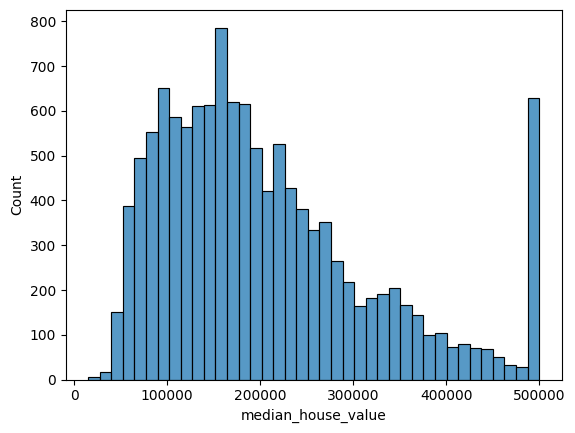

In [29]:
sns.histplot(data=target_train);

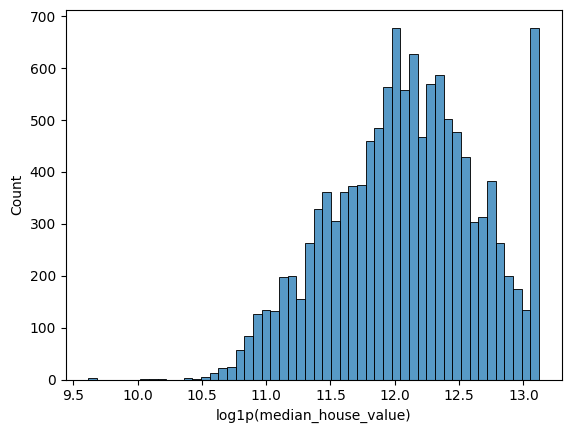

In [30]:
sns.histplot(data=y_train)
plt.xlabel('log1p(median_house_value)');

In [33]:
for alpha in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha=alpha, solver="sag", random_state=42)
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    rmse = round(mean_squared_error(y_val, y_pred_val, squared=False), 5)
    print(f'alpha: {alpha}, rmse: {rmse}')    

alpha: 0, rmse: 0.52406
alpha: 0.01, rmse: 0.52406
alpha: 0.1, rmse: 0.52406
alpha: 1, rmse: 0.52406
alpha: 10, rmse: 0.52406
